[comment]: <> "LTeX: language=fr"
# <center>Dissection d'un transformer : vision de bas niveau</center>
## <center>Jean-Philippe Magué, IXXI</center>
### <center>21 juin 2024</center>


Ce second notebook fait suite au précédent et plonge dans les détails de "bas niveau" de l'architecture du modèle [GPT2](https://huggingface.co/docs/transformers/en/model_doc/gpt2).
# Initialisation

In [1]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
torch.set_grad_enabled(False) #no training today!

In [3]:
model_name = 'openai-community/gpt2'

In [4]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
gpt2 = GPT2LMHeadModel.from_pretrained(model_name,device_map="auto",pad_token_id=tokenizer.eos_token_id)
device = gpt2.device

In [5]:
print(f'GPT2 est un modèle avec {gpt2.config.n_layer} couches et un context de {gpt2.config.n_positions} positions.')

GPT2 est un modèle avec 12 couches et un context de 1024 positions.


# Embeddings

In [17]:
print(f'La dimension du modèle est de {gpt2.config.n_embd} dimensions.')

La dimension du modèle est de 768 dimensions.


768

In [12]:
prompt = " duck chicken goose tiger lion bear train truck plane car boat ship"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| duck|  -> 22045
| chicken| -> 9015
| goose| -> 37246
| tiger| -> 26241
| lion|  -> 18744
| bear|  -> 6842
| train| -> 4512
| truck| -> 7779
| plane| -> 6614
| car|   -> 1097
| boat|  -> 8848
| ship|  -> 4074


In [13]:
all_embeddings = gpt2.transformer.wte.weight.cpu().numpy()

In [14]:
embeddings=all_embeddings[input['input_ids'][0].cpu().numpy()]
embeddings.shape

(12, 768)

In [6]:
prompt = " France Paris Germany Berlin Italy Rome Spain Madrid Belgium Brussels"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| France| -> 4881
| Paris| -> 6342
| Germany| -> 4486
| Berlin| -> 11307
| Italy| -> 8031
| Rome|  -> 10598
| Spain| -> 8602
| Madrid| -> 14708
| Belgium| -> 15664
| Brussels| -> 16445


In [8]:
embeddings=all_embeddings[input['input_ids'][0].cpu().numpy()]
embeddings.shape

(10, 768)

In [9]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(embeddings)

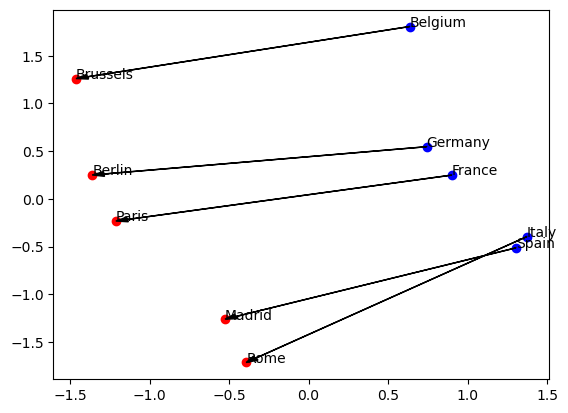

In [10]:
places = prompt.split(' ')[1:]
countries = [2*i for i in range(len(places)//2)]
cities = [2*i+1 for i in range(len(places)//2)]
plt.scatter(coordinates[countries,0],coordinates[countries,1], color='blue')
plt.scatter(coordinates[cities,0],coordinates[cities,1],color='red')
for i in range(len(countries)):
    plt.arrow(coordinates[countries[i],0],coordinates[countries[i],1],coordinates[cities[i],0]-coordinates[countries[i],0],coordinates[cities[i],1]-coordinates[countries[i],1],color='black',head_width=0.05,length_includes_head=True)

for i, place in enumerate(places):
    plt.text(coordinates[i,0],coordinates[i,1],place)